In [1]:
%pylab inline
!pip install natsort

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from natsort import natsorted
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.manual_seed(1)
!nvidia-smi

Populating the interactive namespace from numpy and matplotlib
Tue Mar 22 09:03:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                         

In [154]:
class segments2facades(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform, split=False):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        self.split = split

    def __len__(self):
        return len(self.total_imgs)
           
    def _separate(self, img):
        img = np.array(img, dtype=np.uint8)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if (not self.split):
            return self.transform(image)
        input_t, output_t = self._separate(image)
        input_t, output_t = self.transform(input_t), self.transform(output_t)
        return output_t, input_t

In [170]:
BS = 64
LR = 1e-4
epochs = 20

In [74]:
std_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

facades_ds = segments2facades('../input/pix2pix-dataset/edges2shoes/edges2shoes/train', transform=std_transform)
facades_loader = torch.utils.data.DataLoader(facades_ds, batch_size=BS, shuffle = True, drop_last = True)

Segments vs real


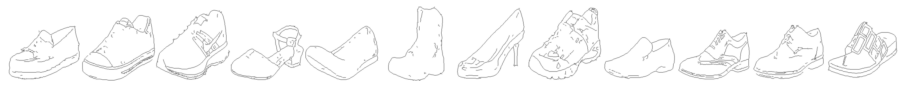

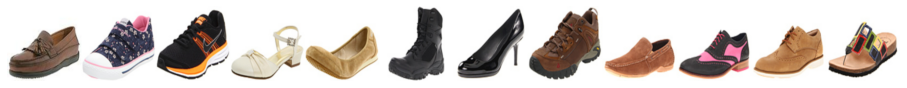

In [75]:
def concat_img(imgs):
    figsize(16,16)
    figure()
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()
    
def print_img(content, style, output):
    printable = torch.cat((content.cpu(), style.cpu(), output.cpu()), 0)
    concat_img((printable).detach().cpu())
    
segment, real = next(iter(facades_loader))
print("Segments vs real")
concat_img(segment[:12])
concat_img(real[:12])

In [86]:
# pix2pix is an image translation model which takes x image and translates it to a y_hat image.
# ej: segments to facade

# CGAN loss: E[log(D(x, y))] + E[log(1-D(x, G(x))]
# Where discriminator wants to maximize the function and generator wants to minimize it

# L1 loss:   E[||y - G(x)||]
# L1 loss rather than L2 eucledian distance to disencourage blurriness.

# Total loss: CGAN_loss + lambda * L1_loss
# To note is the absence of a z noise input for the generator, instead they use dropout at test and train time.

# All blocks are as follows:
# [Conv, Batchnorm, Relu]
# with batchnorm applied both at train and test time

# Generator:
# g: x -> y
# It is a U-Net encoder decoder structure
# First half:
# Ln(Ln-1(x))
# Second half:
# Ln(cat[Ln-1(x), Ln - n/2 - 1()])

torch.cuda.empty_cache()

class Generator(torch.nn.Module):
    def __init__(self, d):
        def block_down(in_c, out_c, kernel, stride, padding, p):
            return [torch.nn.Conv2d(in_c, out_c, kernel, stride, padding),
                    torch.nn.BatchNorm2d(out_c, track_running_stats=False),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(p),
                    ] # Batchnorm and Dropout regardless train or test
        
        def block_up(in_c, out_c, kernel, stride, padding, p, last=False):
            if (last):
                return [torch.nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding),
                        torch.nn.BatchNorm2d(out_c, track_running_stats=False),
                        torch.nn.Tanh(),
                        ] # Batchnorm and Dropout regardless train or test
            return [torch.nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding),
                    torch.nn.BatchNorm2d(out_c, track_running_stats=False),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(p),
                   ]

        super(Generator, self).__init__()
        self.down = torch.nn.Sequential(
            *block_down(3, d, 4, 2, 1, 0), #0
            *block_down(d, d * 2, 4, 2, 1, 0.5), #1
            *block_down(d * 2, d * 4, 4, 2, 1, 0.5), #2
            *block_down(d * 4, d * 8, 4, 2, 1, 0.5), #3
            *block_down(d * 8, d * 8, 4, 2, 1, 0.5), #4
            # ------
            #*block_down(d * 8, d * 8, 4, 2, 1, 0), #5
            #*block_down(d * 8, d * 8, 4, 2, 1, 0), #6
            #*block_down(d * 8, d * 8, 4, 2, 1, 0), #7
        )
        
        self.intermediate = torch.nn.Sequential(
            *block_down(d * 8, d * 8, 4, 2, 1, 0.5),
            *block_up(d * 8, d * 8, 4, 2, 1, 0.5),
        )
        
        self.up = torch.nn.Sequential(
            #*block_up(d * 8, d * 8, 4, 2, 1, 0), # 7
            #*block_up(d * 8 * 2, d * 8, 4, 2, 1, 0), # 6
            #*block_up(d * 8 * 2, d * 8, 4, 2, 1, 0), # 5
            *block_up(d * 8 * 2, d * 8, 4, 2, 1, 0.5), # 4
            *block_up(d * 8 * 2, d * 4, 4, 2, 1, 0.5), # 3 
            *block_up(d * 4 * 2, d * 2, 4, 2, 1, 0.5), # 2
            *block_up(d * 2 * 2, d, 4, 2, 1, 0.5), # 1
            *block_up(d * 2, 3, 4, 2, 1, 0), # 0
        )

    def forward(self, x):
        outputs_down = []
        i = 0
        for layer in self.down:
            x = layer(x)
            if isinstance(layer, torch.nn.LeakyReLU):
                outputs_down.append(x)
        
        x = self.intermediate(x)
    
        for layer in self.up:
            if isinstance(layer, torch.nn.ConvTranspose2d):
                x = layer(torch.cat((x, outputs_down[5 - 1 - i]), 1))
                i += 1
            else:
                x = layer(x)
        return x

G = Generator(64).cuda()
G(segment.cuda()).shape

torch.Size([64, 3, 128, 128])

In [77]:
# Discriminator takes segments and facade, facade can be generated or real
# To note is that the output is not a prediction for the whole image but for 
# different parts of the image (search PATCHGAN)
class Discriminator(torch.nn.Module):
    def __init__(self, d):
        super(Discriminator, self).__init__()
        def block_conv(in_c, out_c, kernel, stride, padding, batchnorm=True):
            if(batchnorm):
                return [torch.nn.Conv2d(in_c, out_c, kernel, stride, padding),
                        torch.nn.BatchNorm2d(out_c),
                        torch.nn.LeakyReLU(0.2),
                        ]
            return [torch.nn.Conv2d(in_c, out_c, kernel, stride, padding),
                   torch.nn.LeakyReLU(0.2)]
        
        self.convos = torch.nn.Sequential(
            *block_conv(6, d, 4, 2, 1, batchnorm=False),
            *block_conv(d, d * 2, 4, 2, 1),
            *block_conv(d * 2, d * 4, 4, 2, 1),
            *block_conv(d * 4, d * 8, 4, 1, 1),
            torch.nn.Conv2d(d * 8, 1, 4, 1, 1),
            torch.nn.Sigmoid(),
        )
    def forward(self, x, y):
        tomonkey = torch.cat((x, y), 1)
        tomonkey = self.convos(tomonkey)
        return tomonkey

#D = Discriminator(64)
#D(segment, real).shape
#d_loss = BinaryCrossEntropy(D([y_hat, y]), [0, 1])
#_loss = BinaryCrossEntropy(D[y_hat], [1]) + alpha * torch.mean(||y - y_hat||1)

In [88]:
alpha = 100
LR = 0.0002

G = Generator(64).cuda()
D = Discriminator(64).cuda()

epochs = 5
g_lr = LR
d_lr = LR
true_label = 0.9
fake_label = 0

g_optim = torch.optim.Adam(G.parameters(), lr=g_lr, betas = (0.5, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=d_lr, betas = (0.5, 0.999))

PATH = '../input/pretrainedv2/pix2pix_gen (2)'
checkpoint = torch.load(PATH)
G.load_state_dict(checkpoint['model_state_dict'])
g_optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

#PATH = '../input/models-pretrained/pix2pix_disc'
#checkpoint = torch.load(PATH)
#D.load_state_dict(checkpoint['model_state_dict'])
#d_optim.load_state_dict(checkpoint['optimizer_state_dict'])
#iters = checkpoint['iters']

In [89]:
def discriminator_loss(inputs, targets):
    BCE = torch.nn.BCELoss().cuda()
    return BCE(inputs, targets)

def generator_loss(d_fake_predictions, generated, real, alpha):
    BCE = torch.nn.BCELoss().cuda()
    L1 = torch.nn.L1Loss().cuda()
    gan_loss = BCE(d_fake_predictions, torch.ones(d_fake_predictions.size()).cuda())
    # l1 loss measures distance between real and generated image
    l1_loss = L1(generated, real)
    return gan_loss + alpha * l1_loss

In [90]:
def adjust_learning_rate(optimiser, iters, learning_rate_decay):
    for param_group in optimiser.param_groups:
        param_group['lr'] = LR / (1.0 + learning_rate_decay * iters)
learning_rate_decay=5e-5

Epoch 0 batch 0 Discriminator loss: 0.060 Generator loss: 18.129


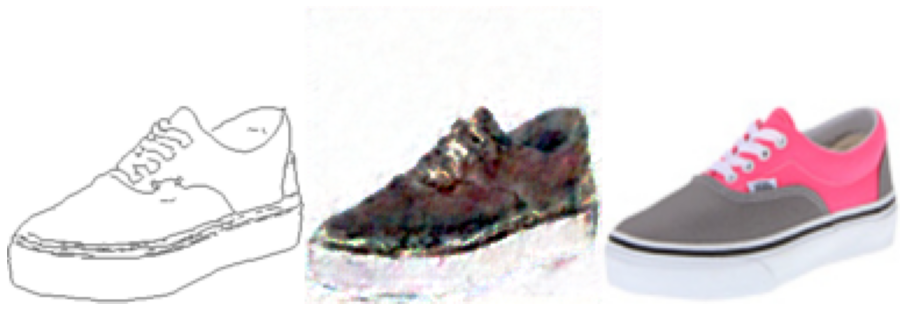

Epoch 0 batch 100 Discriminator loss: 0.005 Generator loss: 20.876
Epoch 0 batch 200 Discriminator loss: 0.003 Generator loss: 22.359
Epoch 0 batch 300 Discriminator loss: 0.413 Generator loss: 19.567
Epoch 0 batch 400 Discriminator loss: 0.018 Generator loss: 21.083
Epoch 0 batch 500 Discriminator loss: 0.007 Generator loss: 20.298
Epoch 0 batch 600 Discriminator loss: 0.002 Generator loss: 22.258
Epoch 0 batch 700 Discriminator loss: 0.003 Generator loss: 22.134
Epoch 1 batch 0 Discriminator loss: 0.003 Generator loss: 22.200


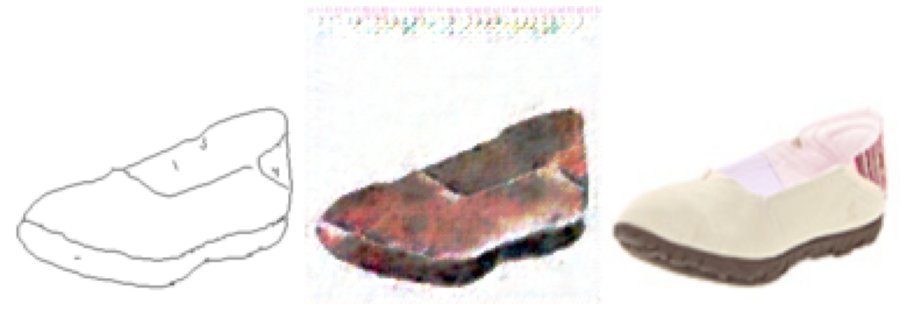

Epoch 1 batch 100 Discriminator loss: 0.002 Generator loss: 21.950
Epoch 1 batch 200 Discriminator loss: 0.002 Generator loss: 21.856
Epoch 1 batch 300 Discriminator loss: 0.001 Generator loss: 22.430
Epoch 1 batch 400 Discriminator loss: 0.001 Generator loss: 23.841
Epoch 1 batch 500 Discriminator loss: 0.002 Generator loss: 25.932
Epoch 1 batch 600 Discriminator loss: 0.001 Generator loss: 27.454
Epoch 1 batch 700 Discriminator loss: 0.002 Generator loss: 24.948
Epoch 2 batch 0 Discriminator loss: 0.002 Generator loss: 22.006


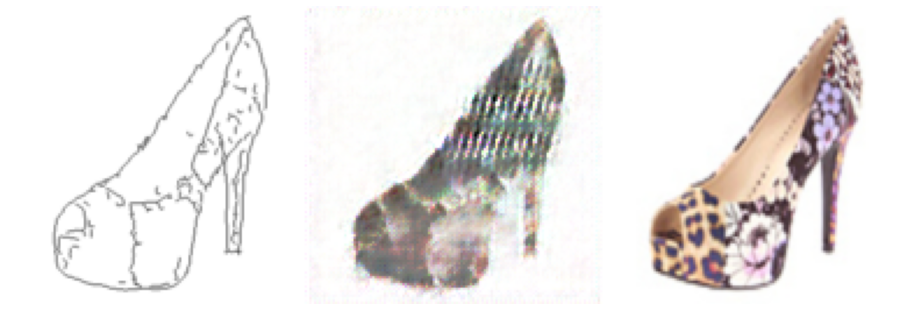

Epoch 2 batch 100 Discriminator loss: 0.445 Generator loss: 15.530


KeyboardInterrupt: 

In [171]:
#torch.autograd.set_detect_anomaly(True)
iters = 0
for epoch in range(epochs):
    G.train()
    D.train()
    for batch_idx, (segment, real) in enumerate(facades_loader):
        segment, real = segment.cuda(), real.cuda()
        
        # Train critic:
        d_optim.zero_grad()
        
        fake = G(segment)
        d_real = D(segment, real)
        d_fake = D(segment, fake)
        predictions = torch.cat((d_real, d_fake), 0)
        targets = torch.cat((torch.ones(d_real.size()).cuda(), torch.zeros(d_fake.size()).cuda()), 0)
        
        d_loss = discriminator_loss(predictions, targets)
            
        d_loss.backward()
        d_optim.step()

        # Train generator:
        g_optim.zero_grad()
        
        fake = G(segment)
        d_fake = D(segment, fake)
        g_loss = generator_loss(d_fake, fake, real, alpha)

        g_loss.backward()
        g_optim.step()
        if (batch_idx % 100 == 0):
            print('Epoch {} batch {} Discriminator loss: {:.3f} Generator loss: {:.3f}'.format(epoch, batch_idx, d_loss, g_loss))
        if (batch_idx % 1000 == 0):
            print_img(segment[:1], fake[:1], real[:1])
            plt.show()
        iters += 1

In [172]:
# Loading validation data to test if it generalizes to unseen images
val_ds = segments2facades('../input/pix2pix-dataset/edges2shoes/edges2shoes/train', transform=std_transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BS, shuffle = True, drop_last = True)

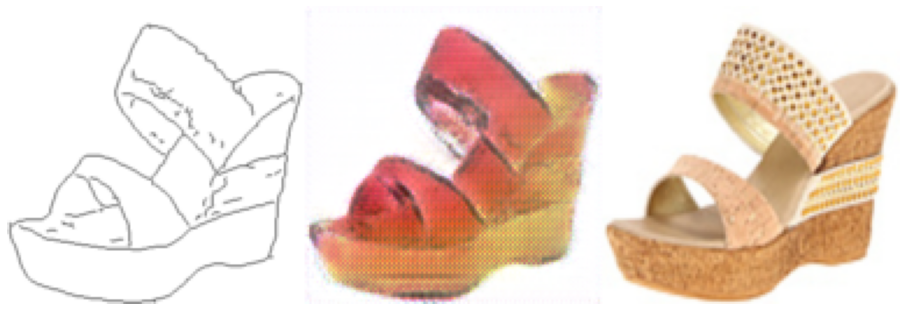

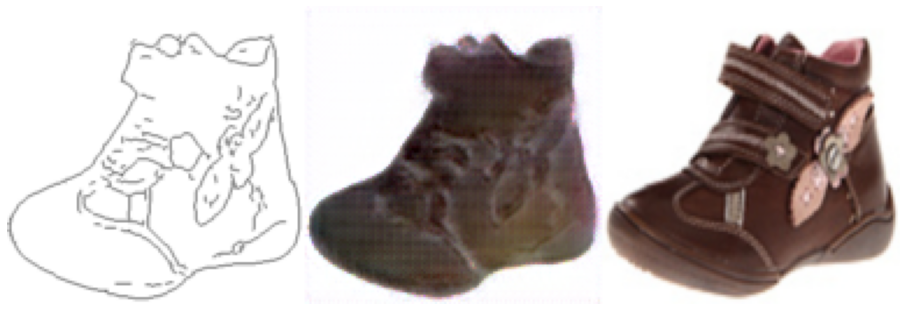

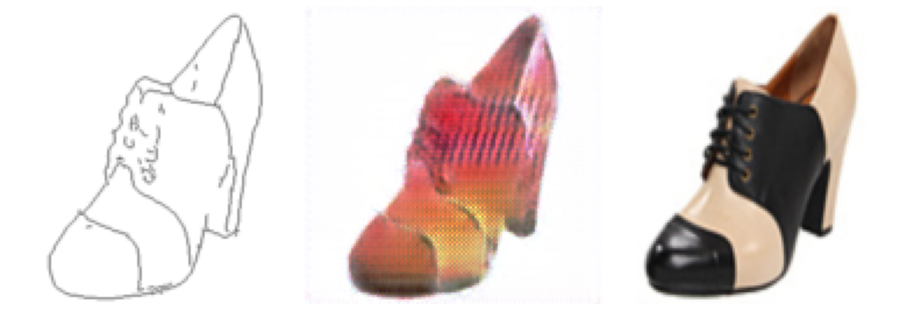

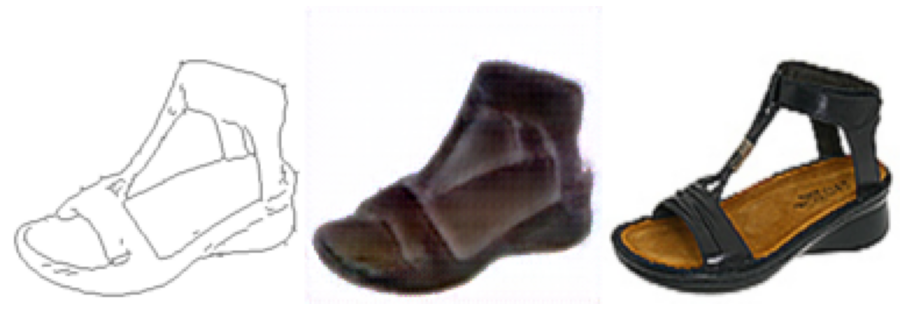

In [173]:
#segment, real = next(iter(val_loader))
#segment, real = segment.cuda(), real.cuda()
G.eval()
fake = G(segment)
sample = 6
print_img(segment[sample - 1:sample], fake[sample - 1:sample], real[sample - 1:sample])
sample += 1
print_img(segment[sample - 1:sample], fake[sample - 1:sample], real[sample - 1:sample])
sample += 1
print_img(segment[sample - 1:sample], fake[sample - 1:sample], real[sample - 1:sample])
sample += 1
print_img(segment[sample - 1:sample], fake[sample - 1:sample], real[sample - 1:sample])

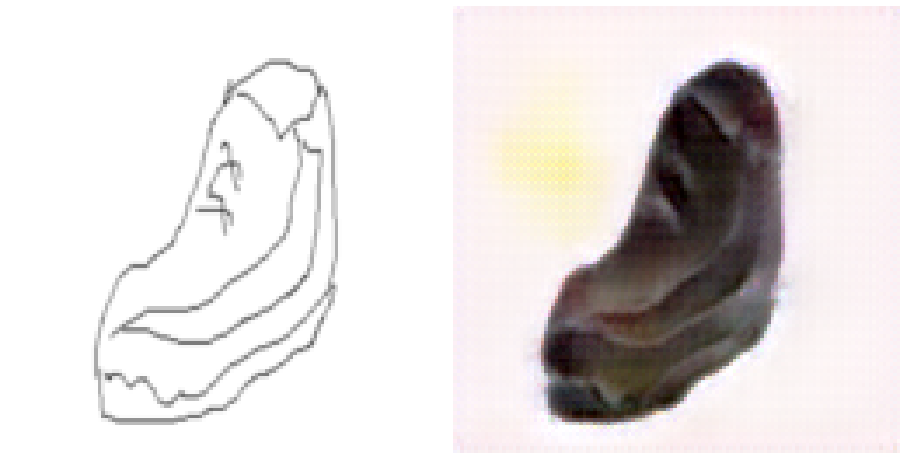

In [174]:
# I tried the model on a shoe I drawed
drawn_ds = segments2facades('../input/hand-drawn', transform=std_transform, split=False)
drawn_loader = torch.utils.data.DataLoader(drawn_ds, batch_size=1, shuffle = True, drop_last = True)

segment = next(iter(drawn_loader))
G.eval()
result = G(segment.cuda())
concat_img(torch.cat((segment[:1].cuda(), result[:1]), 0))

In [175]:
def save_models():
    torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': g_optim.state_dict(),
            'loss': g_loss,
            'iters': iters,
            }, './pix2pix_gen_final')
    torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': d_optim.state_dict(),
            'loss': d_loss,
            'iters': iters,
            }, './pix2pix_disc_final')
save_models()